# 🌏 Configure the environment

If you have not installed any conda envrionments (like Anaconda, Miniconda or Miniforge) on your system, you can install the `conda` package manager by following the instructions on the [github](https://github.com/conda-forge/miniforge).

Afer installing `conda`, you should ensure that `jupyterlab` and `nb_conda_kernels` are installed in the `base` envrionment. This package allows you to use conda environments in Jupyter notebooks. You can install it by running the following command:

```bash
conda install -n base jupyterlab nb_conda_kernels
```

After installing the required packages, you can create a new conda environment for stdyer by running the following command:

```bash
cd stDyer
conda env create -f stdyer.yml
```

After creating the environment, you can switch to the stdyer environment in the VSCode by clicking on the button on the top right corner of the window and selecting the `stdyer` environment.
![vscode-env](tutorial_vscode_env.png)

In [1]:
import hydra
from hydra import compose, initialize
from pytorch_lightning import (
    Callback,
    LightningDataModule,
    LightningModule,
    Trainer,
)
hydra.core.global_hydra.GlobalHydra.instance().clear()
import os.path as osp
import numpy as np
import scanpy as sc
initialize(config_path=osp.join("./", "configs"), version_base="1.3", job_name="test")
import warnings
warnings.filterwarnings("ignore", message=".*does not have many workers*")
warnings.filterwarnings("ignore", message=".*In combination with multi-process data loading*")
warnings.filterwarnings("ignore", message=".*Stochastic Optimizer*")
warnings.filterwarnings("ignore", message=".*is more efficient*")



# 🔍 Check data

The example dataset is the mouse cortex dataset from STARmap technology and is already included in the repository (example_data/20180505_BY3_1kgenes/mouse_cortex.h5ad). It consists of 7 annotated spatial domains, including corpus callosum (CC), hippocampus (HPC), neocortical layer 1 (L1), neocortical layer 2/3 (L2/L3), neocortical layer 4 (L4), neocortical layer 5 (L5), and neocortical layer 6 (L6). The dataset is required to be in '.h5ad' format and contains `spatial` in the `obsm` attribute.


In [2]:
adata = sc.read_h5ad("example_data/20180505_BY3_1kgenes/mouse_cortex.h5ad")
assert "spatial" in adata.obsm
adata.obs['label'].value_counts().sort_index()

CC      154
HPC      69
L1      113
L2/3    262
L4      230
L5      156
L6      223
Name: label, dtype: int64

# 🔢 Specify the parameters

All configurations are stored in the `configs` directory. There are different recipes for specific senarios stored in the `configs/experiment` directory. Here we use the `configs/experiment/dgl_STARmap.yaml` configuration file as an example. Generally, you need to specify the following parameters:

`config.datamodule.data_dir`: The path to the directory containing all datasets;

`config.datamodule.dataset_name`: The name of the directory that contains the dataset;

`config.datamodule.sample_id`: The name of the h5ad file;

`config.datamodule.num_classes`: The number of spatial domains required to be predicted;

`config.datamodule.num_hvg`: The number of used highly variable genes (3000 by default, if #gens < 3000, use all genes);

`config.datamodule.batch_size`: The batch size for training (you can decrease it if you encounter "out of memory error");

`config.model.detect_svg`: The number of spatially variable genes to be selected;

You can also modify relevant parameters in the `configs/experiment/dgl_STARmap.yaml` configuration file to make permanent modifications.

The trainer strategy related to multi-processing is disabled temperarily in the Jupyter notebook environment to avoid issues with the multiprocessing library. 

In [3]:
config = compose(config_name="config", overrides=[f"experiment=dgl_STARmap"])
del config.trainer.strategy
config.datamodule.data_dir = "example_data"
config.datamodule.dataset_dir = "20180505_BY3_1kgenes"
config.datamodule.sample_id = "mouse_cortex"

config.datamodule.num_classes = 7

config.datamodule.num_hvg = 3000

config.datamodule.batch_size = 256

config.model.detect_svg = 50

# 📈 Train the model

The dataset is trained with single-threaded data loading in the jupyter notebook, which can be slow. 

In [4]:
datamodule: LightningDataModule = hydra.utils.instantiate(config.datamodule)
model: LightningModule = hydra.utils.instantiate(config.model)
callbacks = []
if "callbacks" in config:
    for _, cb_conf in config.callbacks.items():
        if "_target_" in cb_conf:
            callbacks.append(hydra.utils.instantiate(cb_conf))
logger = False
plugins = None
trainer = hydra.utils.instantiate(config.trainer, callbacks=callbacks, logger=logger, plugins=plugins, enable_model_summary=False, _convert_="partial")
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kali/miniforge3/envs/stdyer/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /mnt/e/stDyer/stDyer/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━┩
│ 0 │ activation │ ELU  │      0 │
│ 1 │ EXPGMGAT   │ VAE  │  4.8 M │
└───┴────────────┴──────┴────────┘

Trainable params: 4.8 M                                                                                            
Non-trainable params: 4.1 K                                                                                        
Total params: 4.8 M                                                                                                
Total estimated model params size (MB): 19

Output()

Epoch 199 ARI: 0.721490450920548

Epoch 199 smooth_ARI: 0.7561266628388285

`Trainer.fit` stopped: `max_epochs=200` reached.


Alternatively, a faster way is to train the model by running the following command after setting the parameters in the configuration file as above:

```bash
python run.py experiment=dgl_STARmap.yaml
```

# 🔬 Visualize the results

The output is saved to `logs/logger_logs` by default. We can load the saved h5ad file and visualize the results using the `scanpy` package.

In [5]:
adata = sc.read_h5ad("logs/logger_logs/epoch_199.h5ad")
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'label_int', 'is_labelled', 'n_counts', 'pred_labels', 'mlp_outlier', 'mlp_fit'
    var: 'n_counts', 'mean', 'std'
    uns: 'svg_dict'
    obsm: 'X_pca', 'consist_adj', 'prob_cat', 'sp_dist', 'sp_k', 'spatial', 'used_k'
    layers: 'counts', 'scaled', 'unscaled'

Visualize the predicted spatial domains and the smoothened spatial domains.

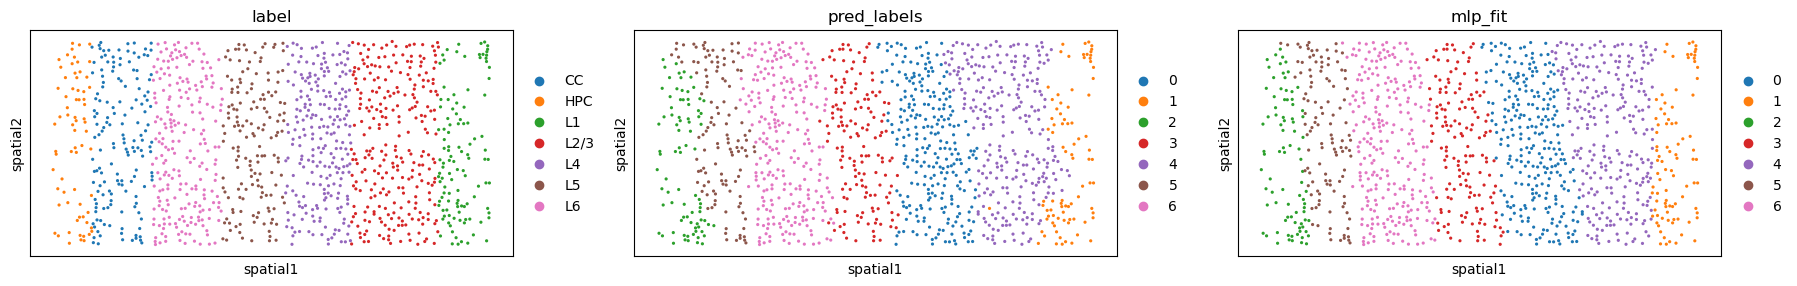

In [6]:
adata.obs["mlp_fit"] = adata.obs["mlp_fit"].astype("category")
sc.pl.spatial(adata, color=["label", "pred_labels", "mlp_fit"], spot_size=100)

The identified spatially variable genes are stored in `adata.uns["svg_dict"]` as a dictionary. The keys are the predicted spatial domains, and the values are the specified number (50 by defaults) of spatially variable genes.

In [7]:
adata.uns["svg_dict"]

{'0': array(['Nrsn1', 'Camk2n1', 'Egr1', 'Nrep', 'Zmat4', 'Tsnax', 'Aldoc',
        'Mef2c', 'Whrn', 'Cadps2', 'Nrgn', 'Sparcl1', 'Pgm2l1', 'Nrn1',
        'Grik1', 'Rorb', '2900055J20Rik', 'Arpp21', 'Nr4a1', 'Bc1', 'Egr3',
        'Atp1a2', 'Satb2', 'Cux2', 'Btbd3', 'Rap1gds1', 'Fkbp1a', 'Hmgcr',
        'Rit2', 'Ncdn', 'Rasgrf1', 'Efna5', 'Epha4', 'Cpne9', 'Phyhip',
        'Arc', 'Spock3', 'Pdp1', 'Ralyl', 'Rgs4', 'Nipsnap3b', 'Slc20a1',
        'Gfra2', 'Glul', 'Slc17a7', 'Phactr1', '1110008P14Rik', 'Dkk3',
        'Mettl23', 'Dync1i1'], dtype=object),
 '1': array(['Camk2n1', 'Camk2a', 'Sparcl1', 'Atp1a2', 'Glul', 'Bsg', 'Fosb',
        'Ncdn', 'Btbd11', 'Itm2a', 'Pcdhb2', 'Maf', 'Ppa2', 'Ptgds',
        'Slc2a13', 'Dusp1', 'Egr3', 'Mapk3', 'Ythdf1', 'Slc38a3', 'Aqp4',
        'Myo5b', 'Gm15881', 'Btbd3', 'Slc7a3', 'Rgs2', 'Nat8f1', 'Egr4',
        'Sgk1', 'Usp46', 'Etv1', 'Pfn1', 'Ptk2b', 'Abat', 'Pde11a',
        'Aldh1l1', 'Ly6e', 'Rasgrf1', 'Rgs8', 'Junb', 'Nr2f2', 'Pcsk5',
   

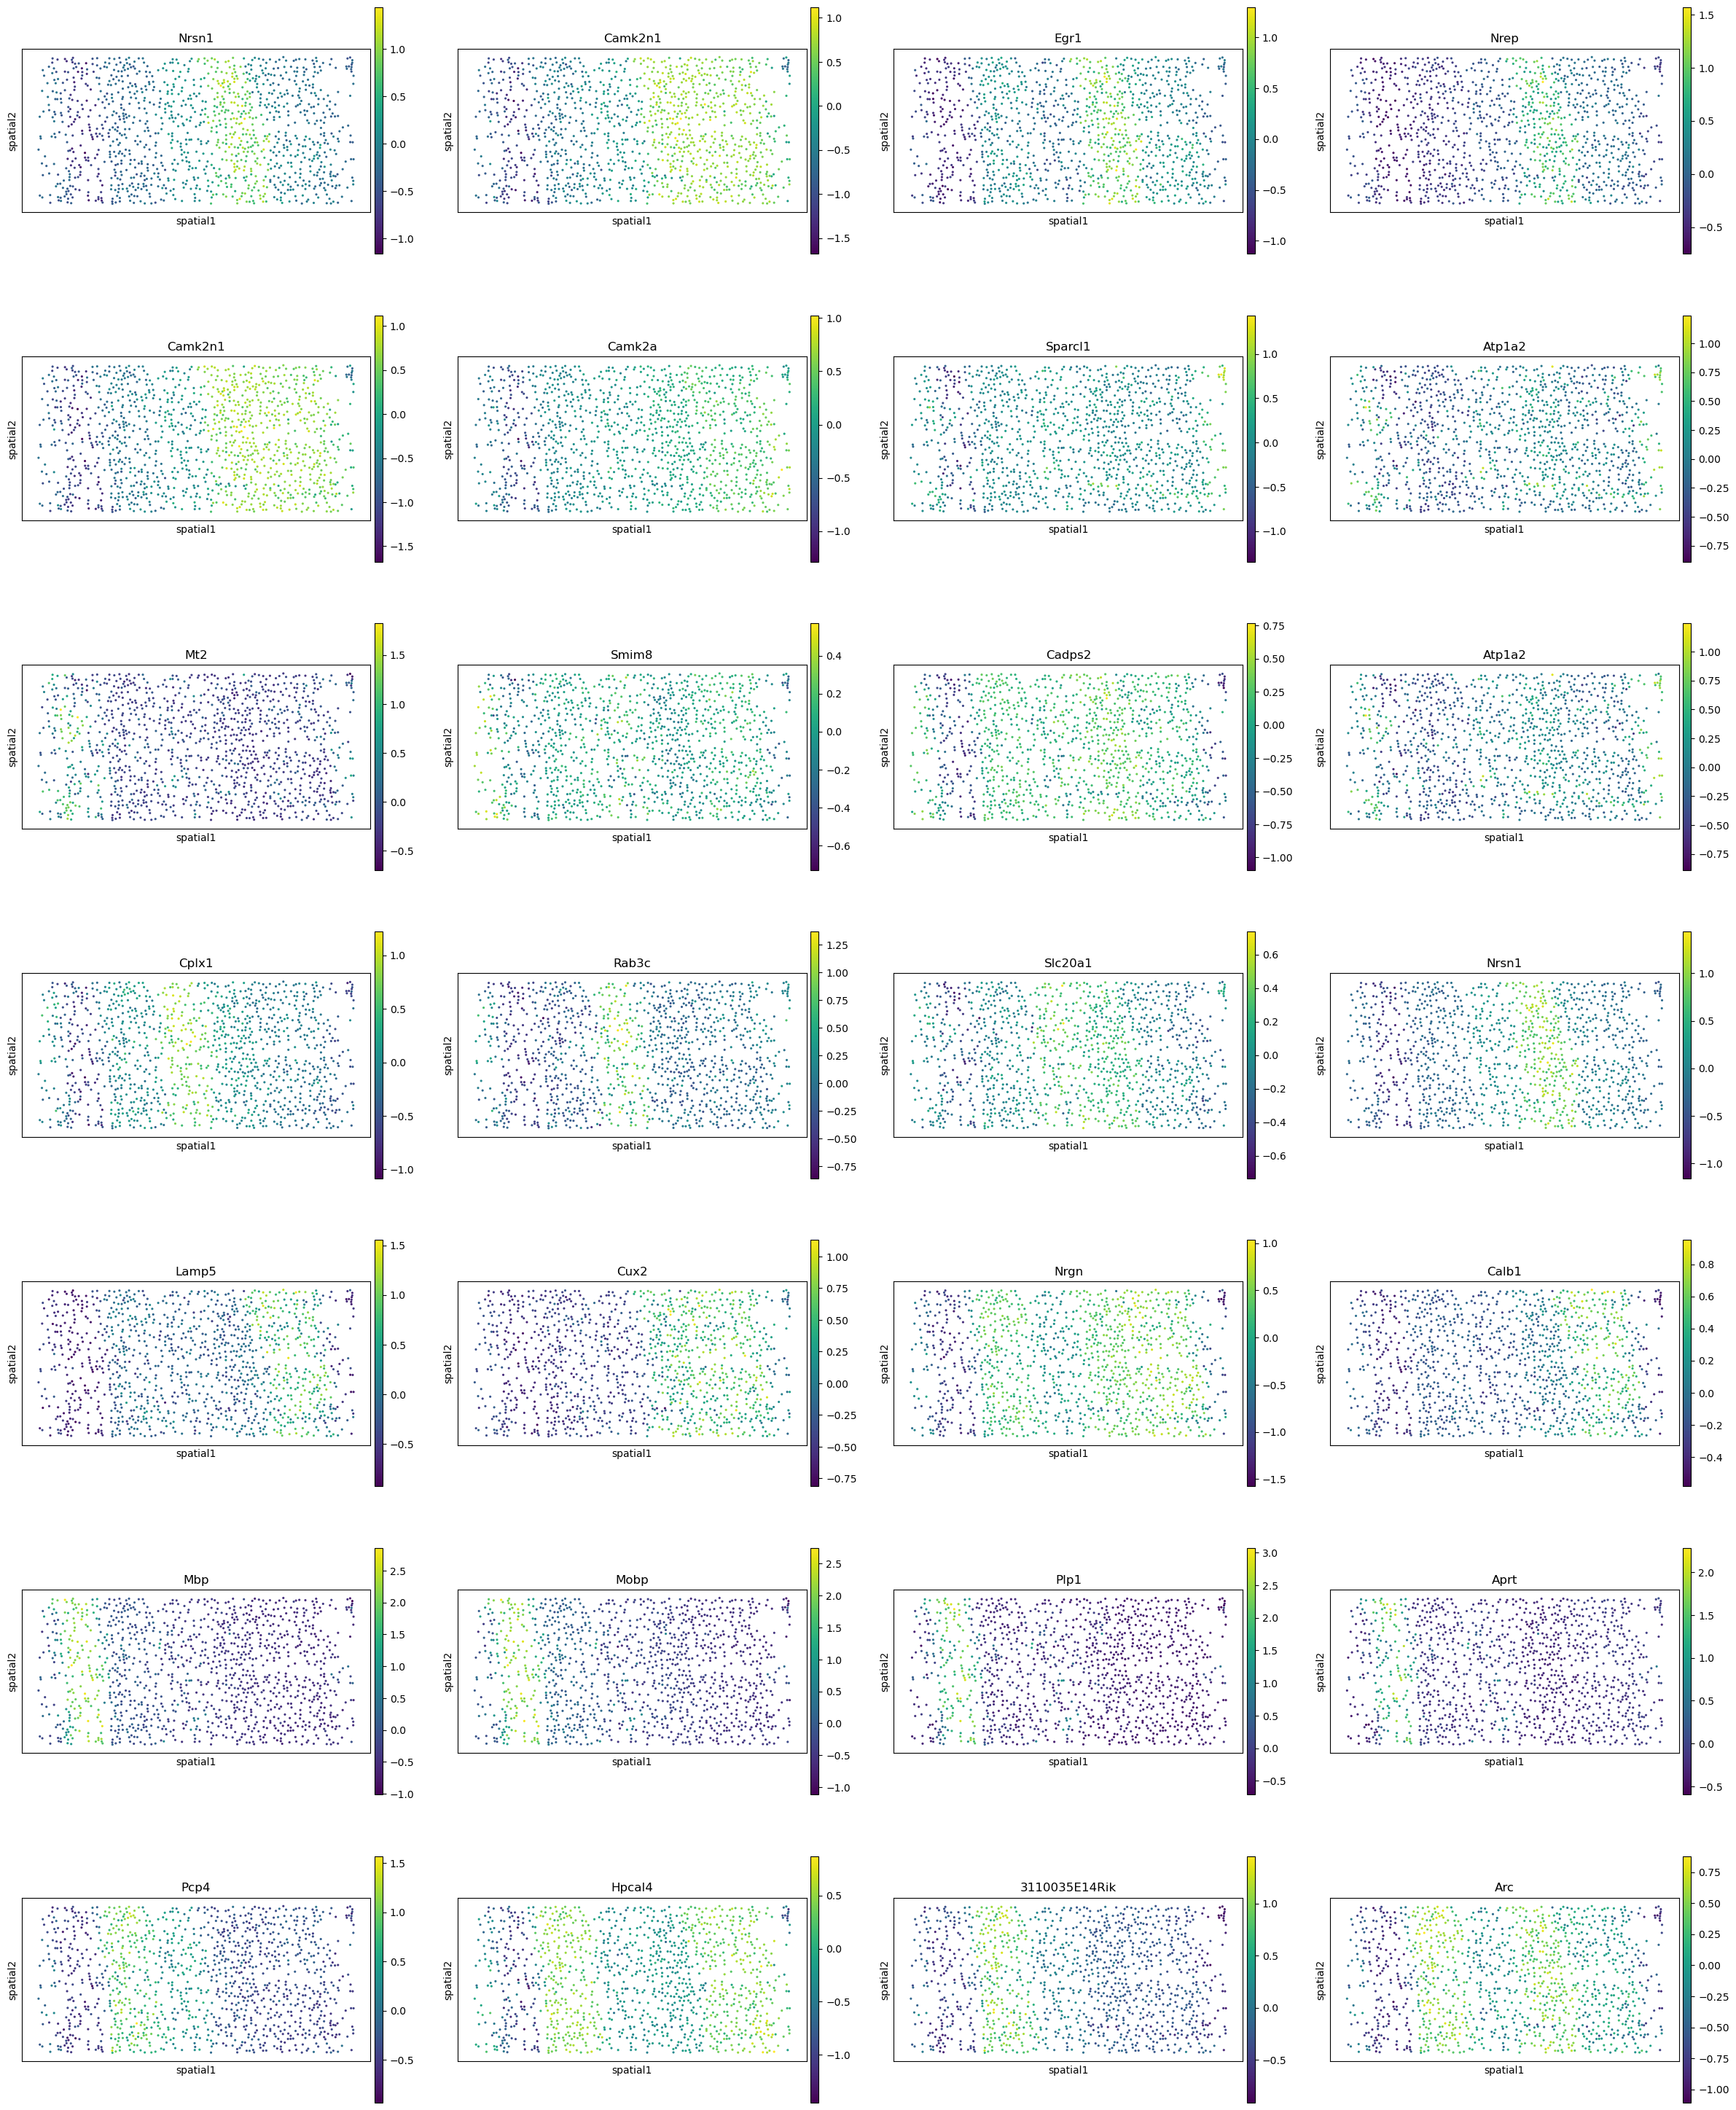

In [8]:
svgs = np.array([v[:4] for v in adata.uns["svg_dict"].values()]).flatten()
sc.pl.spatial(adata, color=svgs, spot_size=100)